# Quantum Black Holes - Orbital Precession 
(Suzanne Parr)

Here we will consider a bound orbit of a massive object, like a planet, around a spherically symmetric central body. If the angle swept out by the object in one period is more than $2\pi$ the orbit is said to be 'precessing'. 

The research goal is to understand how quantum effects can alter orbital precession for a massive object orbiting a black hole. General relativity, as delineated by the Schwarzschild metric, predicts orbital precession for a particle in an orbit just offset from the effective potential minimum.

To study orbits we begin by solving for $r(\phi)$. Effectively, we are integrating $\frac{dr}{d\phi}$.

$$\frac{dr}{d\phi} = \frac{\dot{r}}{\dot{\phi}} = \frac{h(r)}{L} \left( \frac{1}{f(r)g(r)} \left( E^2 - f(r) \left( \epsilon + \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$

Orbital precession is calculated using,

$$2 \left| \int_{R^-}^{R^+} \frac{d\phi}{dr} \, dr \right| = \int_0^{2\pi + \Delta\phi} d\phi = \Delta\phi + 2\pi$$

where the integrand is,

$$\frac{d\phi}{dr} = \frac{L}{h(r)} \left( \frac{1}{f(r)g(r)} \left( E^2 - f(r) \left( \epsilon + \frac{L^2}{h(r)} \right) \right) \right)^{-\frac{1}{2}}$$

At perihelion ($r(\phi)$ min) and aphelion ($r(\phi)$ max) radial velocity goes to zero and, 

$$\frac{dr}{d\phi}(R^-) = 0 \quad \text{and} \quad \frac{dr}{d\phi}(R^+) = 0$$

We can use the above expressions to solve for E, L as functions of $R^+$ and $R^-$ then substitute them back into our expression for $\frac{d\phi}{dr}$ (the integrand).


In [1]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.signal import find_peaks
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math
import matplotlib.animation as animation

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

In [2]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# The Euler-Langrange Equations #

To plot trajectories, start with the Point Particle Lagrangian (describes particle motion in a SC spacetime):

$$L = g_{\mu\nu} \dot{x}^\mu \dot{x}^\nu = -f(r)\dot{t}^2 + g(r)\dot{r}^2 + h(r)\left( \dot{\theta}^2 + \sin^2(\theta)\dot{\phi}^2 \right)$$

Spherical symmetry means we can confine motion to the equatorial plane and if we integrate once (with respect to $\theta$), we get 3 components of motion that we can solve to get $r(\phi)$,

$$\frac{dt}{d\lambda} = \frac{E}{f(r)}$$

$$\frac{d\phi}{d\lambda} = \frac{L}{h(r)}$$

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

In [3]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions and effective potential.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)


# Assign Values to Constants

Assign values for Mass (M) of central massive object, Angular momentum (L) of the orbiting body, and a set of test values for the quantum parameter, $Q_b$ to see how quantum effects alter effective potential. We ignore $Q_c$ (set it equal to 0) since $Q_b$ has a much larger effect and $Q_c$ is negligable by comparison.

In [4]:
# block 2 - assign values to parameters
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
L1 = 3.8 # angular momentum of orbiting particle

# Effective Potential and Minima

What follows is a function "find_extrema" that uses Scipy's root_scalar to find the roots. Here we are interested in finding the minima for the case of a massive particle ($\epsilon = 1$) for a pre-selected value of angular momentum, L = 3.8. Then we call "find_extrema" in a loop and store the $Q_b$ value, r, $V_{\text{eff}}(r)$, and 'max/min' in an array for use in plotting. 

As $Q_b$ increases from 0 to 1 the minima are located at larger r and at higher values of $V_{\text{eff}}(r)$.

In [5]:
# block 3 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.0, Q_c = 0.0:
r = 4.2521, v_eff = 0.9526, Type: max
r = 10.1879, v_eff = 0.9155, Type: min


**OGRePy**: You have the latest version of the package.


Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.25, Q_c = 0.0:
r = 3.9526, v_eff = 0.9736, Type: max
r = 10.6394, v_eff = 0.9179, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.5, Q_c = 0.0:
r = 3.6820, v_eff = 0.9990, Type: max
r = 11.0603, v_eff = 0.9200, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.75, Q_c = 0.0:
r = 3.4322, v_eff = 1.0299, Type: max
r = 11.4584, v_eff = 0.9220, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 1.0, Q_c = 0.0:
r = 3.1978, v_eff = 1.0673, Type: max
r = 11.8389, v_eff = 0.9239, Type: min


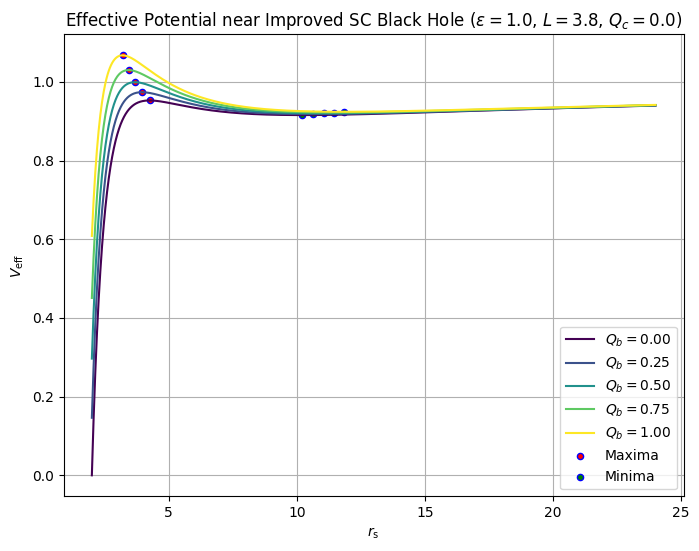

In [6]:
#block 4 - find v_eff max/min for the timelike case for different values of Q_b and create array for the results
r_range = (rs1, 12 * rs1)
eps = 1.0

Q_b_vals = np.linspace(0, 1.0, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, Q_b, ext_type))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Effective Potential near Improved SC Black Hole ($\varepsilon={eps}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, Q_b val, extrema type
extrema_array = np.array(extrema_data)


In [7]:
# Print extrema_array
# print r(at v_max), v_max, Q_b, 'max'/'min') for Q_b = (0.0, 0.25, 0.50, 0.75, 1.0)
print(extrema_array[:, 0:4])

[[4.252105123155472 0.952648157123989 0.0 'max']
 [10.187894876844528 0.915499991024160 0.0 'min']
 [3.9525552339709655 0.973632508060842 0.25 'max']
 [10.639436315287034 0.917861413009015 0.25 'min']
 [3.6819500007353896 0.999048633929920 0.5 'max']
 [11.060320492712115 0.920026218088792 0.5 'min']
 [3.4321548831313233 1.02985154575437 0.75 'max']
 [11.458443833132666 0.922028329247097 0.75 'min']
 [3.1977915564419943 1.06733670374179 1.0 'max']
 [11.838899084624854 0.923892491584209 1.0 'min']]


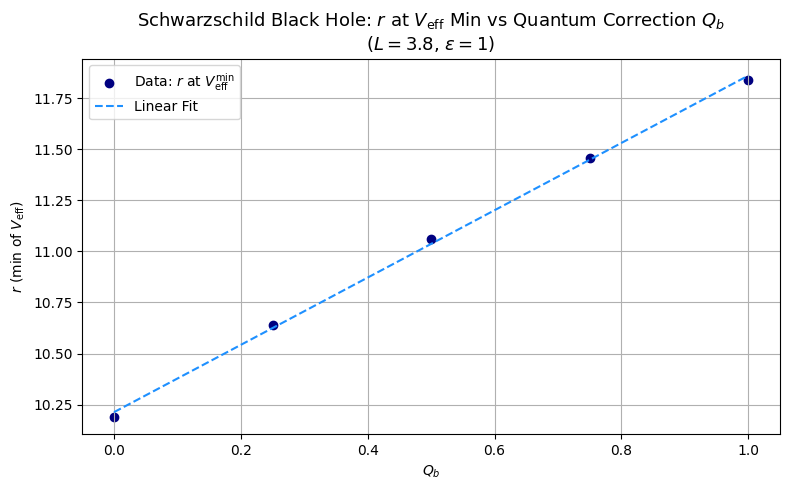

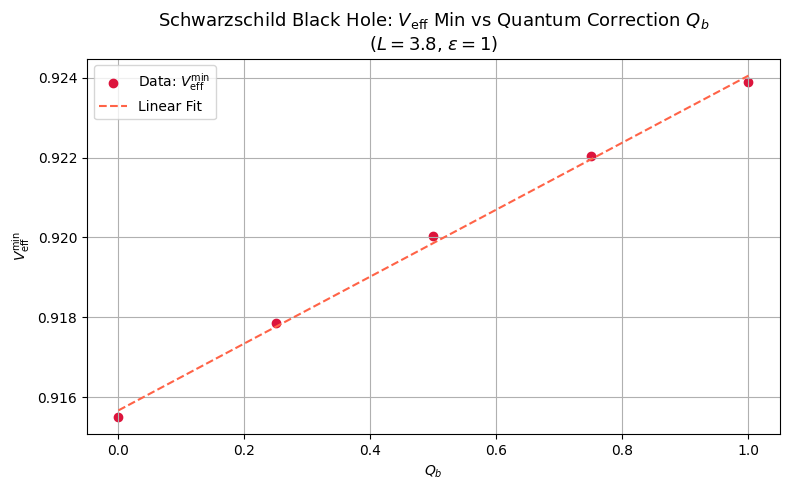

In [8]:
# Block 5 - plots of Q_b vs r and V_max
# extrema_array = np.array(extrema_data, dtype=object)

minima = extrema_array[extrema_array[:, 3] == 'min']

# Extract values
r_vals_min = np.array(minima[:, 0], dtype=float)
v_min_vals = np.array(minima[:, 1], dtype=float)
Q_b_vals_min = np.array(minima[:, 2], dtype=float)

# --- Fit a straight line: r_min vs Q_b ---
fit_r = np.polyfit(Q_b_vals_min, r_vals_min, 1)  # Linear fit: degree 1
fit_r_func = np.poly1d(fit_r)

# --- Fit a straight line: V_min vs Q_b ---
fit_v = np.polyfit(Q_b_vals_min, v_min_vals, 1)
fit_v_func = np.poly1d(fit_v)

# --- Plot 1: r_min vs Q_b with best-fit line ---
plt.figure(figsize=(8, 5))
plt.scatter(Q_b_vals_min, r_vals_min, color='navy', label=r'Data: $r$ at $V_{\mathrm{eff}}^{\min}$')
plt.plot(Q_b_vals_min, fit_r_func(Q_b_vals_min), color='dodgerblue', linestyle='--', label='Linear Fit')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$r$ (min of $V_{\mathrm{eff}}$)')
plt.title(r'Schwarzschild Black Hole: $r$ at $V_{\mathrm{eff}}$ Min vs Quantum Correction $Q_b$' + "\n" + rf'($L={L1}$, $\varepsilon=1$)', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: V_min vs Q_b with best-fit line ---
plt.figure(figsize=(8, 5))
plt.scatter(Q_b_vals_min, v_min_vals, color='crimson', label=r'Data: $V_{\mathrm{eff}}^{\min}$')
plt.plot(Q_b_vals_min, fit_v_func(Q_b_vals_min), color='tomato', linestyle='--', label='Linear Fit')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$V_{\mathrm{eff}}^{\min}$')
plt.title(r'Schwarzschild Black Hole: $V_{\mathrm{eff}}$ Min vs Quantum Correction $Q_b$' + "\n" + rf'($L={L1}$, $\varepsilon=1$)', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [9]:
# block 6 - ODE Solver
def solve_bound_orbit(r_init, phi_init, t_init, lam_range, params, epsilon=1):
    E, L, M, Q_b, Q_c = params
    sign = -1  # Start moving inward
    flipped_on_this_neg = False

    # Check squared at the initial radius before integrating
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Initial squared is negative. You're starting in a classically forbidden region.")
        # to prevent immediate outward motion, set flipped flag to True
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def plunge_event(lam, y):
        r = y[1]
        return r - (2 * M)
    plunge_event.terminal = True
    plunge_event.direction = -1

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=plunge_event,
        max_step=0.2
    )

    if sol.status == 1:
        print("plunge detected — integration stopped.")

    t_vals = sol.y[0]
    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    return t_vals, r_vals, phi_vals


# Particle Orbits ($\epsilon$ = 1) with Quantum Corrections

For M = 1.0 and L = 3.8 there is the possibility for a bound orbit with orbital precession close to $r_\text{min}$ if $E^2$ of the particle is slightly higher than $V_{\text{eff}}(r_\text{min})$. 

Next: select the total Energy for each $Q_b$ value such that $E^2 = 1.002 \, V_{\text{eff}}(r_0)$ i.e. a bit higher than $V_{\text{eff}}(r_\text{min})$ and, where $r_0 = r_\text{min} + 0.005$ i.e. just outside $r_\text{min}$.

In [10]:
# Block 7 - Find Energy Levels (E^2 = V(r_min) or E^2 = V(r_start))
E_sq0 = float(v_eff((float(extrema_array[1, 0]) + 0.005), M1, L1, Q_b0, Q_c0, epsilon=1)) * 1.002
E0 = np.sqrt(E_sq0)
print(E0)
E_sq1 = float(v_eff((float(extrema_array[3, 0]) + 0.005), M1, L1, Q_b1, Q_c0, epsilon=1)) * 1.002
E1 = np.sqrt(E_sq1)
print(E1)
E_sq2 = float(v_eff((float(extrema_array[5, 0]) + 0.005), M1, L1, Q_b2, Q_c0, epsilon=1)) * 1.002
E2 = np.sqrt(E_sq2)
print(E2)
E_sq3 = float(v_eff((float(extrema_array[7, 0]) + 0.005), M1, L1, Q_b3, Q_c0, epsilon=1)) * 1.002
E3 = np.sqrt(E_sq3)
print(E3)
E_sq4 = float(v_eff((float(extrema_array[9, 0]) + 0.005), M1, L1, Q_b4, Q_c0, epsilon=1)) * 1.002
E4 = np.sqrt(E_sq4)
print(E4)

0.957773984193611
0.9590084195676675
0.9601386788840244
0.9611828115991263
0.9621539831401532


# Particle Orbits ($\epsilon$ = 1) with Quantum Corrections

For M = 1.0 and L = 3.8 there is the possibility for a bound orbit close to the $V_{\text{eff}}(r)$ minima if the total energy of the particle is just above the minima. If ($Q_b$ = 0) a minimum exists at 10.19; if ($Q_b$ = 0.5) a minimum exists at 11.06; and if ($Q_b$ = 1.0) a mimumum exists at 11.84. As $Q_b$ increases from 0 to 1 the minima are located at larger r and at higher values of $V_{\text{eff}}(r)$. 

Next: using the array of minima for $V_{\text{eff}}(r)$ for different values of $Q_b$ we can pinpoint the r values where a bound orbit can be and observe and plot orbital precession.

In [11]:
# block 8 - create data for bound plots for time-like case (epsilon = 1)
phi_init = 0.0
t_init = 0.0
lam_range0 = [0,1500]
eps = 1.0
#----------- Q_b = 0 ------------------#
Qb_val0 = float(extrema_array[1, 2])
r_init0 = float(extrema_array[1, 0]) + 0.005
# E_val0 = E0 * 1.001
E_val0 = E0
params0 = (E_val0, L1, M1, Qb_val0, Q_c0)

r_0 = np.linspace(rs1, 12*rs1, 1000)
v_eff_0 = np.array([v_eff(i, M1, L1, Qb_val0, Q_c0, epsilon=1) for i in r_0])

t_vals0, r_vals0, phi_vals0 = solve_bound_orbit(r_init0, phi_init, t_init, lam_range=lam_range0, params=params0)

x_vals0 = r_vals0 * np.cos(phi_vals0)
y_vals0 = r_vals0 * np.sin(phi_vals0)

#---------- Q_b = 0.25 -------------
Qb_val1 = float(extrema_array[3, 2])
r_init1 = float(extrema_array[3, 0]) + 0.005
# E_val1 = E1 * 1.001
E_val1 = E1
params1 = (E_val1, L1, M1, Qb_val1, Q_c0)

v_eff_1 = np.array([v_eff(i, M1, L1, Qb_val1, Q_c0, epsilon=1) for i in r_0])

t_vals1, r_vals1, phi_vals1 = solve_bound_orbit(r_init1, phi_init, t_init, lam_range=lam_range0, params=params1)

x_vals1 = r_vals1 * np.cos(phi_vals1)
y_vals1 = r_vals1 * np.sin(phi_vals1)

#---------- Q_b = 0.5 -------------
Qb_val2 = float(extrema_array[5, 2])
r_init2 = float(extrema_array[5, 0]) + 0.005
# E_val2 = E2 * 1.001
E_val2 = E2
params2 = (E_val2, L1, M1, Qb_val2, Q_c0)

v_eff_2 = np.array([v_eff(i, M1, L1, Qb_val2, Q_c0, epsilon=1) for i in r_0])

t_vals2, r_vals2, phi_vals2 = solve_bound_orbit(r_init2, phi_init, t_init, lam_range=lam_range0, params=params2)

# cartesian coordinates
x_vals2 = r_vals2 * np.cos(phi_vals2)
y_vals2 = r_vals2 * np.sin(phi_vals2)

#---------- Q_b = 0.75 -------------
Qb_val3 = float(extrema_array[7, 2])
r_init3 = float(extrema_array[7, 0]) + 0.005
# E_val3 = E3 * 1.001
E_val3 = E3
params3 = (E_val3, L1, M1, Qb_val3, Q_c0)

v_eff_3 = np.array([v_eff(i, M1, L1, Qb_val3, Q_c0, epsilon=1) for i in r_0])

t_vals3, r_vals3, phi_vals3 = solve_bound_orbit(r_init3, phi_init, t_init, lam_range=lam_range0, params=params3)

x_vals3 = r_vals3 * np.cos(phi_vals3)
y_vals3 = r_vals3 * np.sin(phi_vals3)

#---------- Q_b = 1.0 -------------
Qb_val4 = float(extrema_array[9, 2])
r_init4 = float(extrema_array[9, 0]) + 0.005
# E_val4 = E4 * 1.001
E_val4 = E4
params4 = (E_val4, L1, M1, Qb_val4, Q_c0)

v_eff_4 = np.array([v_eff(i, M1, L1, Qb_val4, Q_c0, epsilon=1) for i in r_0])

t_vals4, r_vals4, phi_vals4 = solve_bound_orbit(r_init4, phi_init, t_init, lam_range=lam_range0, params=params4)

x_vals4 = r_vals4 * np.cos(phi_vals4)
y_vals4 = r_vals4 * np.sin(phi_vals4)


Initial squared: 0.0018310000095768234
Initial squared: 0.0018316813332029467
Initial squared: 0.001832569002103956
Initial squared: 0.0018335918143408273
Initial squared: 0.0018347059284094598


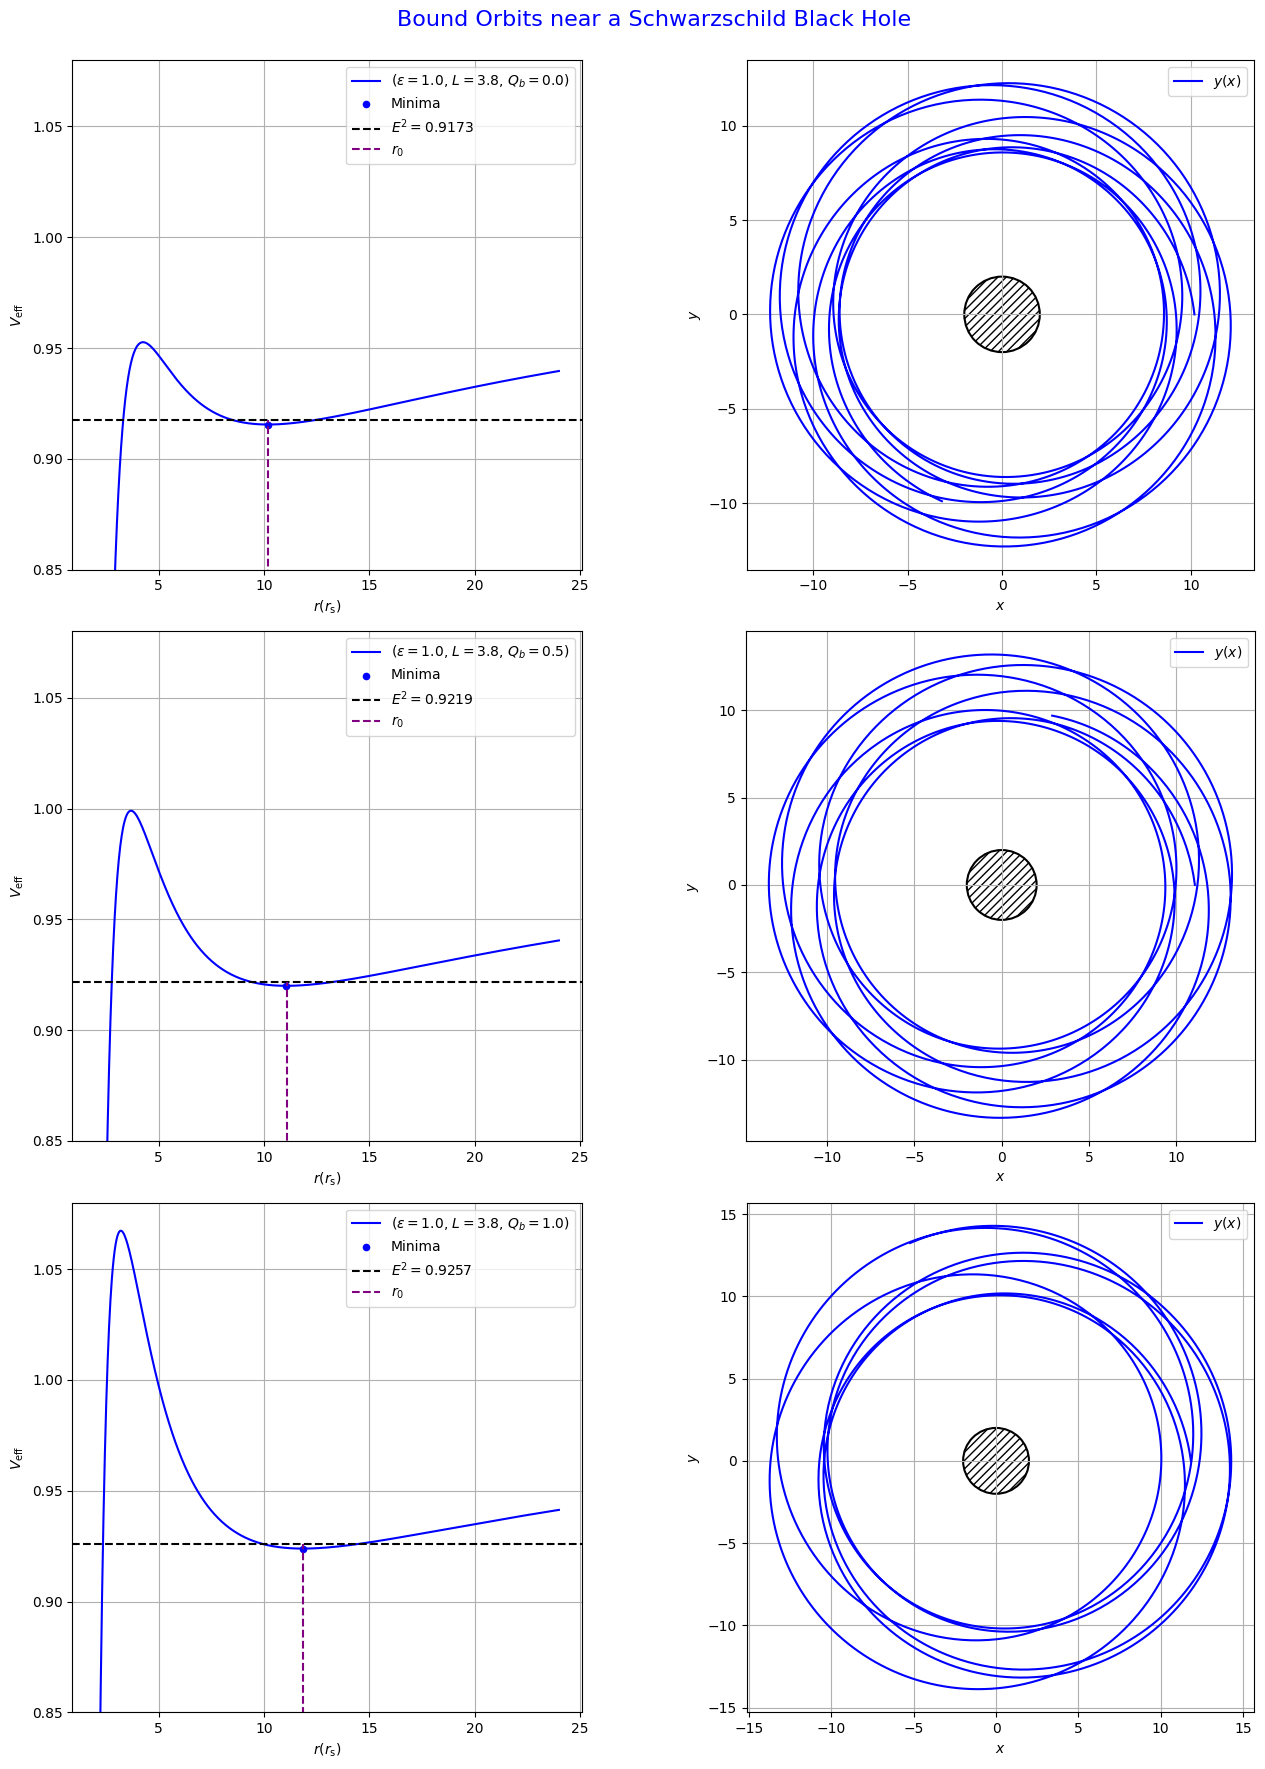

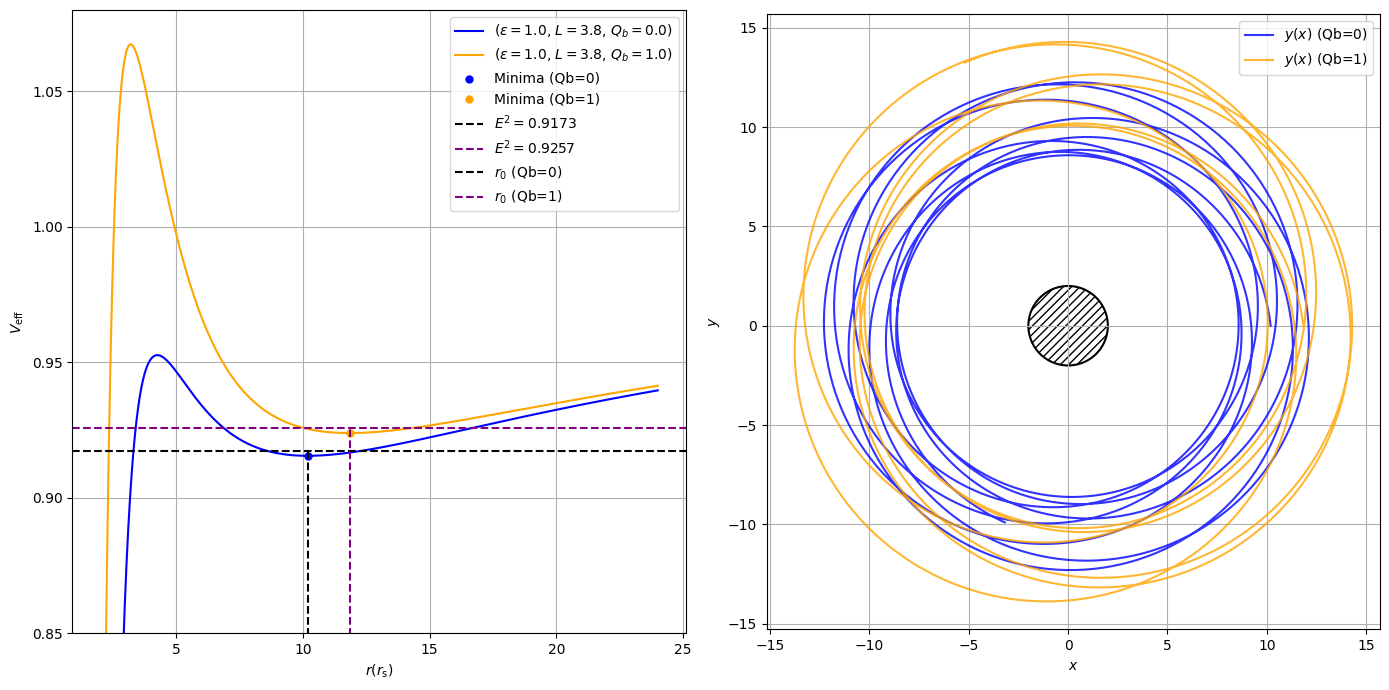

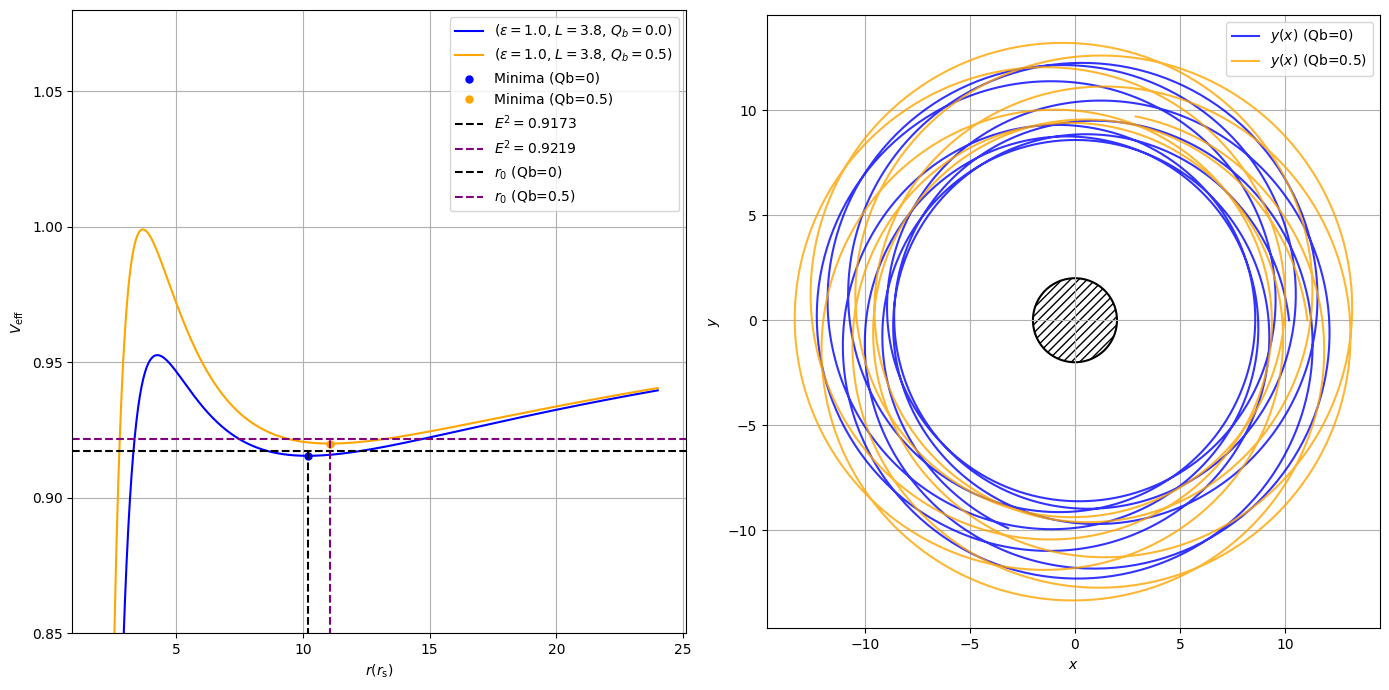

In [12]:
# Block 9 - bound orbit plots 
# --------- plots for Qb = 0, 0.5, 1.0 -----------#
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

for i in range(3): 
    axes[i, 0].set_box_aspect(1)  # landscape for eff. potential plots
    axes[i, 1].set_aspect('equal')  # square for orbit plots

# plot 1
axes[0, 0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0, 0].scatter(extrema_array[1,0], extrema_array[1,1], color='b', s=20, edgecolors='b', label="Minima")
axes[0, 0].axhline(y=E_sq0, color='black', linestyle='--', label=rf'$E^2 = {E_sq0:.4f}$')
axes[0, 0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_sq0, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylim(0.85, 1.08)  

# plot 2
axes[0, 1].plot(x_vals0, y_vals0, label=r'$y(x)$', color='b')
circle1_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle1_1)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# plot 3
axes[1, 0].plot(r_0, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='b')
axes[1, 0].scatter(extrema_array[5,0], extrema_array[5,1], color='b', s=20, edgecolors='b', label="Minima")
axes[1, 0].axhline(y=E_sq2, color='black', linestyle='--', label=rf'$E^2 = {E_sq2:.4f}$')
axes[1, 0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_sq2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_ylim(0.85, 1.08)  

# plot 4
axes[1, 1].plot(x_vals2, y_vals2, label=r'$y(x)$', color='b')
circle2_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle2_1)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# plot 5
axes[2, 0].plot(r_0, v_eff_4, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='b')
axes[2, 0].scatter(extrema_array[9,0], extrema_array[9,1], color='b', s=20, edgecolors='b', label="Minima")
axes[2, 0].axhline(y=E_sq4, color='black', linestyle='--', label=rf'$E^2 = {E_sq4:.4f}$')
axes[2, 0].vlines(x=r_init4, ymin=min(v_eff_4), ymax=E_sq4, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()
axes[2, 0].set_ylim(0.85, 1.08)  

# plot 6
axes[2, 1].plot(x_vals4, y_vals4, label=r'$y(x)$', color='b')
circle3_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle3_1)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

# ---- titles ---- #
fig.suptitle("Bound Orbits near a Schwarzschild Black Hole", color='b', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

# -------overlay plots Qb = 0, 1 and Qb = 0, 0.5 - full dataset -----------#
# -------overlay plots Qb = 0, 1 -----------#
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0].plot(r_0, v_eff_4, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='orange')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='b', s=25, edgecolors='b', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[9, 0], extrema_array[9, 1], color='orange', s=25, edgecolors='orange', label="Minima (Qb=1)")
axes[0].axhline(y=E_sq0, color='black', linestyle='--', label=rf'$E^2 = {E_sq0:.4f}$')
axes[0].axhline(y=E_sq4, color='purple', linestyle='--', label=rf'$E^2 = {E_sq4:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_sq0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init4, ymin=min(v_eff_4), ymax=E_sq4, color='purple', linestyle='--', label=r'$r_0$ (Qb=1)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  # Limit y-axis to start at 0.4
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals0, y_vals0, label=r'$y(x)$ (Qb=0)', color='b', alpha=0.8)  
axes[1].plot(x_vals4, y_vals4, label=r'$y(x)$ (Qb=1)', color='orange', alpha=0.8) 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# -------overlay plots Qb = 0, 0.5 -----------#
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0].plot(r_0, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='orange')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='b', s=25, edgecolors='b', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[5, 0], extrema_array[5, 1], color='orange', s=25, edgecolors='orange', label="Minima (Qb=0.5)")
axes[0].axhline(y=E_sq0, color='black', linestyle='--', label=rf'$E^2 = {E_sq0:.4f}$')
axes[0].axhline(y=E_sq2, color='purple', linestyle='--', label=rf'$E^2 = {E_sq2:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_sq0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_sq2, color='purple', linestyle='--', label=r'$r_0$ (Qb=0.5)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  # limit y-axis to start at 0.85
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals0, y_vals0, label=r'$y(x)$ (Qb=0)', color='b', alpha=0.8) 
axes[1].plot(x_vals2, y_vals2, label=r'$y(x)$ (Qb=0.5)', color='orange', alpha=0.8) 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

2000


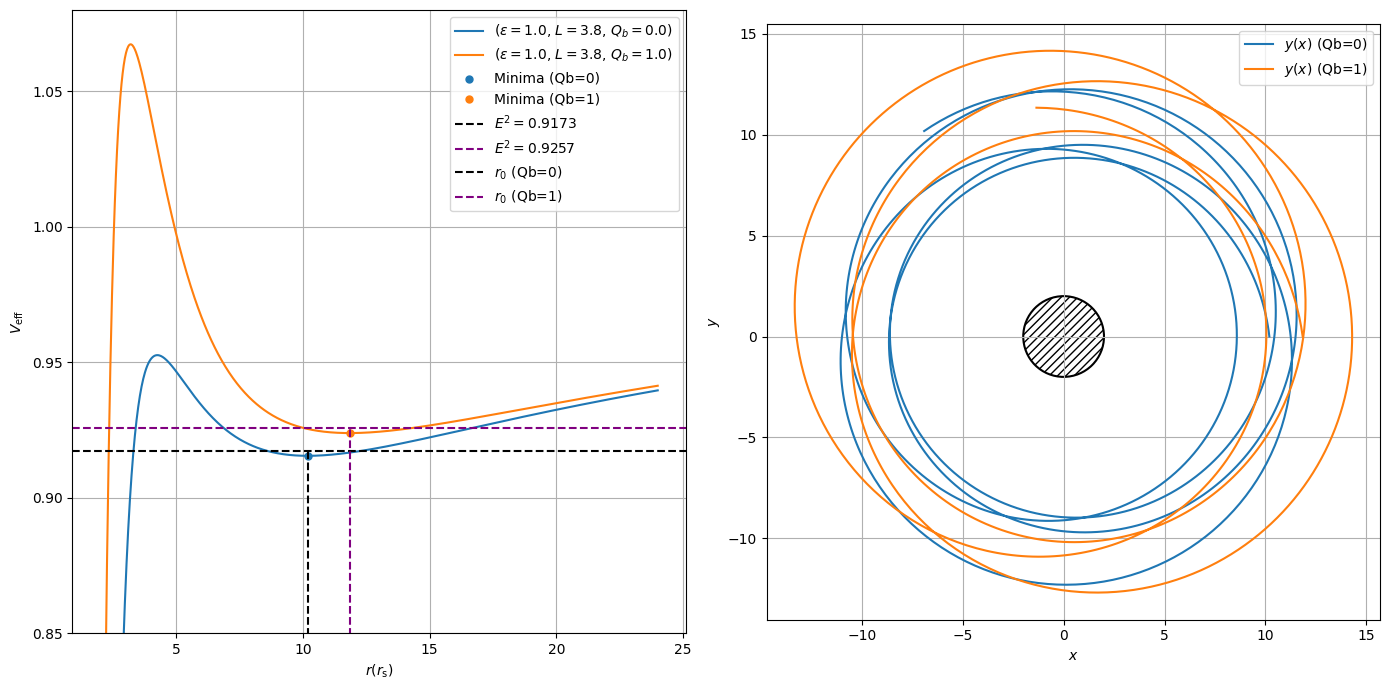

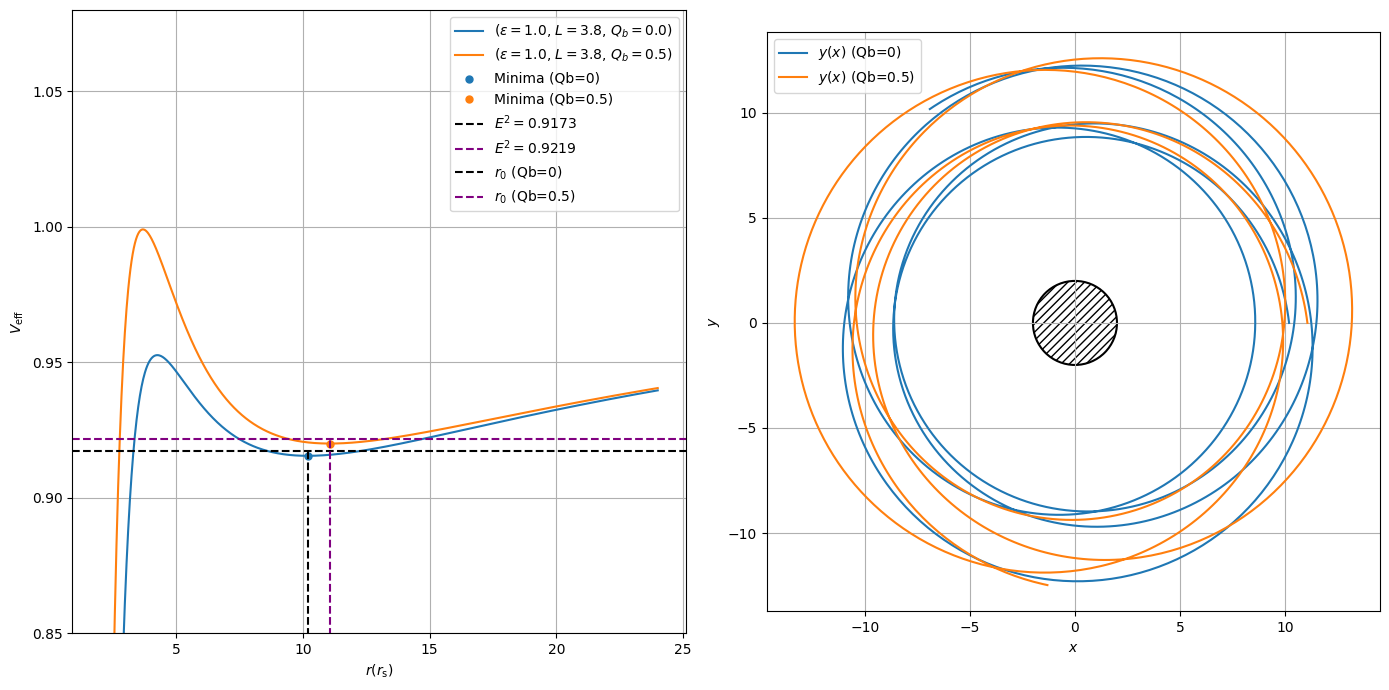

In [13]:
# Block 10 - bound orbit trimmed
# ---- overlay plots for Qb = 0, 1 and Qb = 0.5, 1 - trimmed data -----#
# ---- trim data to 1000 bits (if necessary) ----#
n = 1000
print(len(r_vals4))
r_vals0_trim = r_vals0[:n]
phi_vals0_trim = phi_vals0[:n]

r_vals2_trim = r_vals2[:n]
phi_vals2_trim = phi_vals2[:n]

r_vals4_trim = r_vals4[:n]
phi_vals4_trim = phi_vals4[:n]

# cartesian coordinates
x_vals0_trim = r_vals0_trim * np.cos(phi_vals0_trim)
y_vals0_trim = r_vals0_trim * np.sin(phi_vals0_trim)

x_vals2_trim = r_vals2_trim * np.cos(phi_vals2_trim)
y_vals2_trim = r_vals2_trim * np.sin(phi_vals2_trim)

x_vals4_trim = r_vals4_trim * np.cos(phi_vals4_trim)
y_vals4_trim = r_vals4_trim * np.sin(phi_vals4_trim)
#------- overlay plot Qb = 0, 1 - trimmed data -------------#
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='C0')
axes[0].plot(r_0, v_eff_4, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='C1')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='C0', s=25, edgecolors='C0', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[9, 0], extrema_array[9, 1], color='C1', s=25, edgecolors='C1', label="Minima (Qb=1)")
axes[0].axhline(y=E_sq0, color='black', linestyle='--', label=rf'$E^2 = {E_sq0:.4f}$')
axes[0].axhline(y=E_sq4, color='purple', linestyle='--', label=rf'$E^2 = {E_sq4:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_sq0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init4, ymin=min(v_eff_4), ymax=E_sq4, color='purple', linestyle='--', label=r'$r_0$ (Qb=1)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits
axes[1].plot(x_vals0_trim, y_vals0_trim, label=r'$y(x)$ (Qb=0)', color='C0')  
axes[1].plot(x_vals4_trim, y_vals4_trim, label=r'$y(x)$ (Qb=1)', color='C1') 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()
#------- overlay plot Qb = 0, 0.5 - trimmed data -------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='C0')
axes[0].plot(r_0, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='C1')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='C0', s=25, edgecolors='C0', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[5, 0], extrema_array[5, 1], color='C1', s=25, edgecolors='C1', label="Minima (Qb=0.5)")
axes[0].axhline(y=E_sq0, color='black', linestyle='--', label=rf'$E^2 = {E_sq0:.4f}$')
axes[0].axhline(y=E_sq2, color='purple', linestyle='--', label=rf'$E^2 = {E_sq2:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_sq0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_sq2, color='purple', linestyle='--', label=r'$r_0$ (Qb=0.5)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals0_trim, y_vals0_trim, label=r'$y(x)$ (Qb=0)', color='C0') 
axes[1].plot(x_vals2_trim, y_vals2_trim, label=r'$y(x)$ (Qb=0.5)', color='C1') 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# Calculate Perihelion Shift #

Calculate the minima (perihelion) and maxima (aphelion) from a plot of $\phi(r)$. Measure the average angular separation between successive perihelia and subtract $2\pi$ to obtain the perihelion shift i.e.,

$ d\phi = \Delta\phi - 2\pi $

With the initial conditions chosen, Perhihelion Shift decreases by 1.57 radians for $Q_b=1.0$ as compared to an object in orbit around a class Schwarzschild black hole ($Q_b=0$).

In [14]:
# Block 11 - function to plot phi(r) to get r_min (aphelion)
def process_phi_vs_r(r_vals, phi_vals, Qb_val, E_val, L_val, plot=True):
    # find minima and maxima (perihelion/aphelion)
    min_indices, _ = find_peaks(-r_vals)
    max_indices, _ = find_peaks(r_vals)

    r_mins = r_vals[min_indices]
    phi_mins = phi_vals[min_indices]
    r_maxs = r_vals[max_indices]
    phi_maxs = phi_vals[max_indices]

    # plot phi(r) with labeled extrema
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(r_vals, phi_vals, label=r"$\phi(r)$", lw=2)
        plt.scatter(r_mins, phi_mins, color='red', label="Perihelion", zorder=5)
        plt.scatter(r_maxs, phi_maxs, color='blue', label="Aphelion", zorder=5)

        for i in range(len(r_mins)):  # Label all perihelion points
            plt.annotate(f"{i}", (r_mins[i], phi_mins[i]), textcoords="offset points", xytext=(5,5), ha='center', color='red')
        for i in range(len(r_maxs)):  # Label all aphelion points
            plt.annotate(f"{i}", (r_maxs[i], phi_maxs[i]), textcoords="offset points", xytext=(5,5), ha='center', color='blue')

        plt.xlabel("r")
        plt.ylabel(r"$\phi$ (radians)")
        plt.title(fr"Perihelion Shift: $\phi$ vs. Radius (E={E_val:.4f}, L={L_val:.2f}, Q_b={Qb_val:.2f})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # compute average perihelion shift from phi values
    if len(phi_mins) >= 2:
        delta_phis = np.diff(phi_mins) % (2 * np.pi)
        avg_shift = np.mean(delta_phis)
    else:
        avg_shift = np.nan 

    return avg_shift


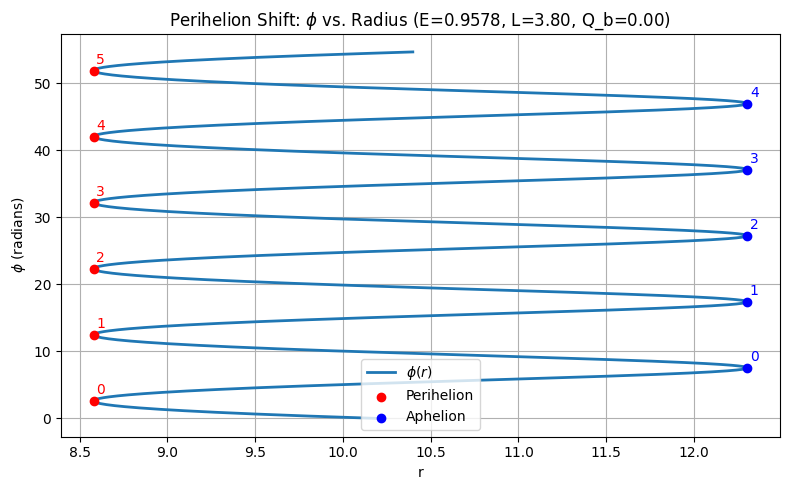

Q_b = 0.00 -> ⟨Δφ⟩ = 3.573301 rad


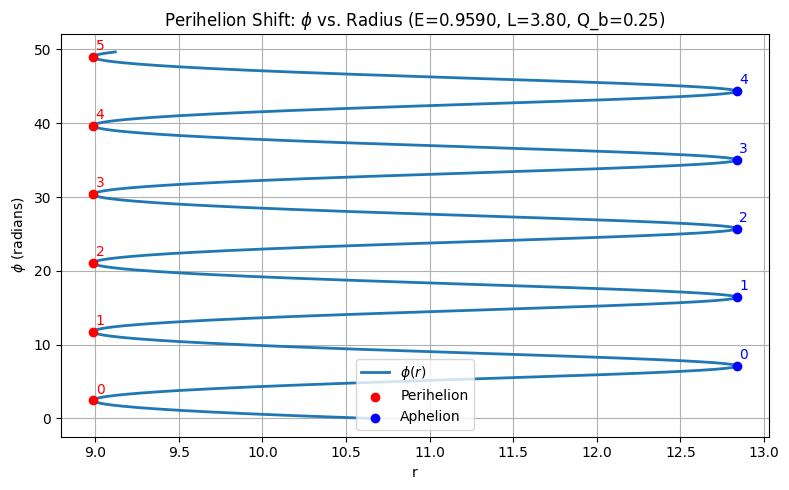

Q_b = 0.25 -> ⟨Δφ⟩ = 3.030247 rad


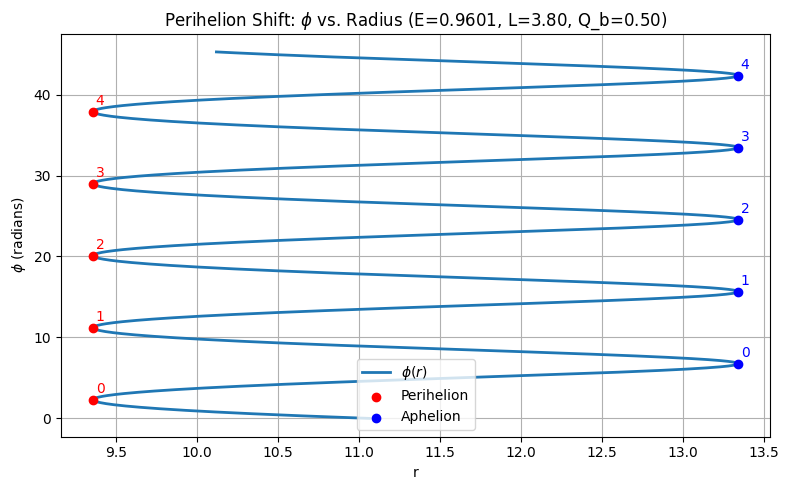

Q_b = 0.50 -> ⟨Δφ⟩ = 2.615946 rad


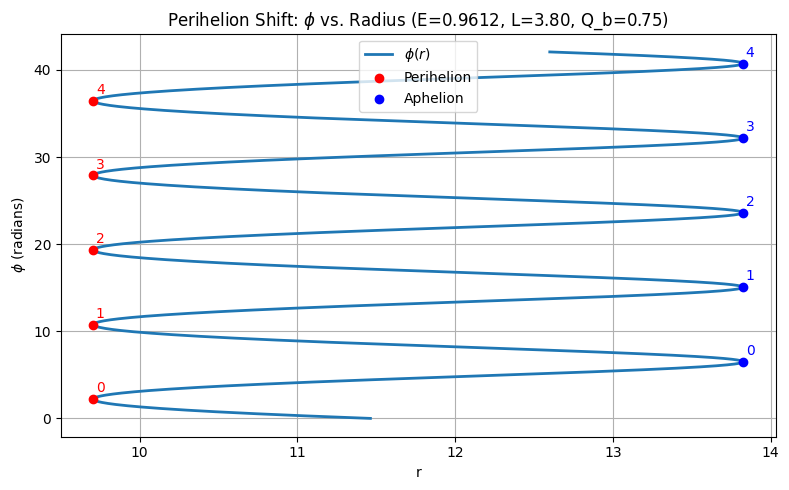

Q_b = 0.75 -> ⟨Δφ⟩ = 2.275721 rad


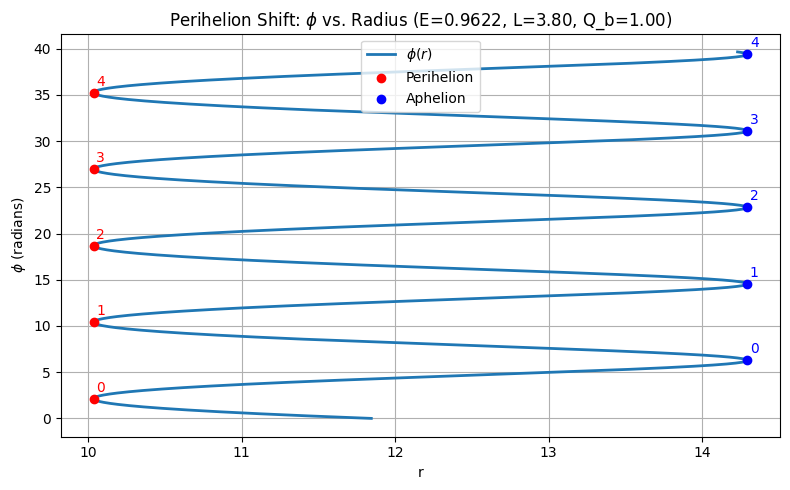

Q_b = 1.00 -> ⟨Δφ⟩ = 1.997528 rad


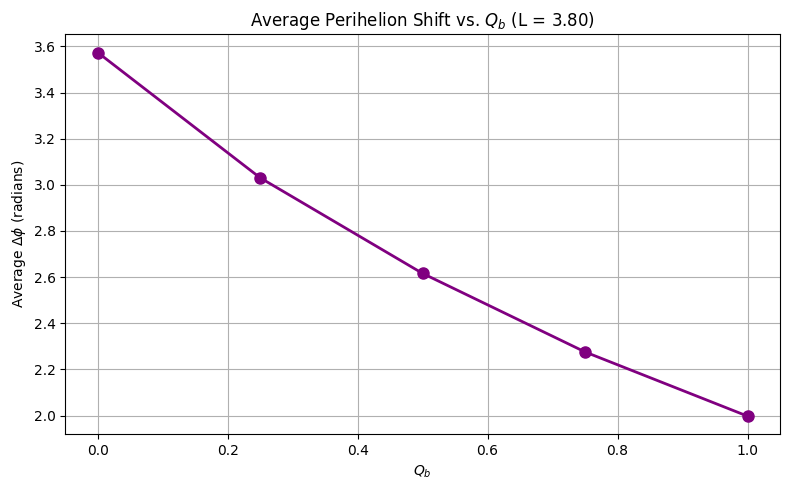

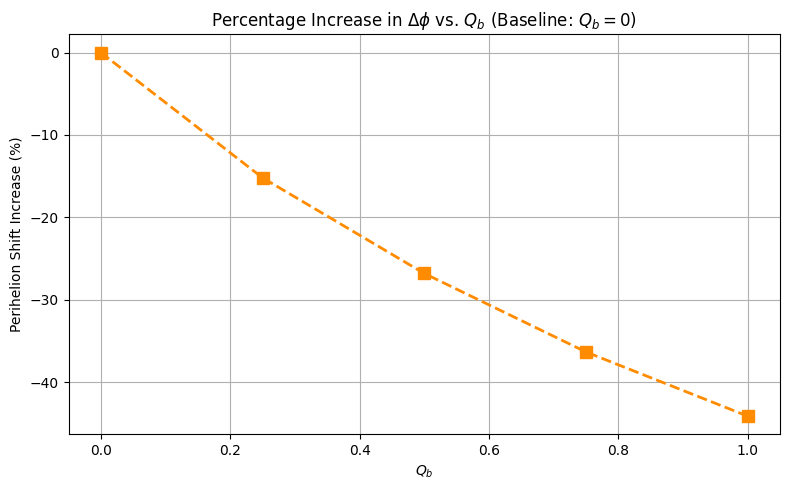


Percentage increase from Q_b = 0 to Q_b = 1.0: -44.10%


In [15]:
# Block 12 - calculate perihelion shift for previously created datasets
# ----- get average angular distance between successive minima & subtract 2pi ------#
Qb_vals = [Qb_val0, Qb_val1, Qb_val2, Qb_val3, Qb_val4]
r_list   = [r_vals0, r_vals1, r_vals2, r_vals3, r_vals4]
phi_list = [phi_vals0, phi_vals1, phi_vals2, phi_vals3, phi_vals4]
E_vals   = [E_val0, E_val1, E_val2, E_val3, E_val4]

delta_phis = []

for i in range(len(Qb_vals)):
    dphi = process_phi_vs_r(r_list[i], phi_list[i], Qb_vals[i], E_vals[i], L1)
    delta_phis.append(dphi)
    print(f"Q_b = {Qb_vals[i]:.2f} -> ⟨Δφ⟩ = {dphi:.6f} rad")

plt.figure(figsize=(8, 5))
plt.plot(Qb_vals, delta_phis, 'o-', color='purple', lw=2, markersize=8)
plt.xlabel(r"$Q_b$")
plt.ylabel(r"Average $\Delta\phi$ (radians)")
plt.title(fr"Average Perihelion Shift vs. $Q_b$ (L = {L1:.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()
#------- plot percentage increase in perihelion shift -----
delta_phis = np.array(delta_phis)

# Q_b = 0 value is the baseline
baseline_shift = delta_phis[0]

percent_increase_vals = ((delta_phis - baseline_shift) / baseline_shift) * 100

plt.figure(figsize=(8, 5))
plt.plot(Qb_vals, percent_increase_vals, 's--', color='darkorange', lw=2, markersize=8)
plt.xlabel(r"$Q_b$")
plt.ylabel(r"Perihelion Shift Increase (%)")
plt.title(fr"Percentage Increase in $\Delta\phi$ vs. $Q_b$ (Baseline: $Q_b = 0$)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nPercentage increase from Q_b = 0 to Q_b = 1.0: {percent_increase_vals[-1]:.2f}%")
